# Análise exploratória de dados

## Carregar bibliotecas

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt
from nltk import ngrams
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import nltk 
import cv2

### Paleta de Cores

In [2]:
sns.set_palette("colorblind")

## Dicionário de dados

In [3]:
pd.read_csv('../data/external/dicionario.csv')

,variavel,significado,tipo,Unnamed: 3
0,id,ID único por usuário,nominal,NaN
1,tweet_text,Texto publicado,nominal,NaN
2,tweet_date,Data de publicação,nominal,NaN
3,sentiment,Algorítmo de classificação do sentimento do us...,nominal,"[0,1,2]"
4,query_used,Palavra relevante,nominal,"[':)', ':(', 'veja', 'jornaloglobo', 'g1', 'fo..."


## Leitura do arquivo de dados

In [4]:
db = pd.read_csv('../data/raw/data.csv', delimiter=";")
db.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


## 1. Descrição dos dados

In [5]:
# Quantidade de linhas x colunas
db.shape

(100000, 5)

O conjunto de dados possui $1 \times 10^5$ instâncias e cinco colunas, das quais 3 correspondem a variáveis discretas e duas a variáveis qualitativas.

In [6]:
# Nome das colunas que representam as variáveis
db.columns

Index(['id', 'tweet_text', 'tweet_date', 'sentiment', 'query_used'], dtype='object')

In [7]:
#Tipo e contagem por coluna
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   tweet_text  100000 non-null  object
 2   tweet_date  100000 non-null  object
 3   sentiment   100000 non-null  int64 
 4   query_used  100000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


In [8]:
# Número de valores nulos
db.isnull().sum()

id            0
tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

O conjunto de dados não apresenta valores nulos. 

## 1.1. Obtenção dos períodos do dia

In [9]:
# obtenção de dados do dataset
db['date'] = pd.to_datetime(db['tweet_date'])

#conversão do horário para UTC -3
db['date'] = db.date.dt.tz_convert('Brazil/East')

# padronização em horas
db['period'] = db['date'].dt.hour % 24

# dicionário com horários
db['period'].replace({0: '00h-06h', 1: '00h-06h', 2: '00h-06h', 3: '00h-06h', 4: '00h-06h', 5: '00h-06h', 
                      6: '06h-12h', 7: '06h-12h', 8: '06h-12h', 9: '06h-12h', 10: '06h-12h', 11: '06h-12h',      
                     12: '12h-18h', 13: '12h-18h', 14: '12h-18h', 15: '12h-18h', 16: '12h-18h', 17: '12h-18h',     
                     18: '18h-24h', 19: '18h-24h', 20: '18h-24h', 21: '18h-24h', 22: '18h-24h', 23: '18h-24h'}, inplace=True) 

# sentimento
db['sentiment'].replace({0: 'Negative',
                         1: 'Positive',
                         2: 'Neutral'}, inplace=True)

db.head()

,id,tweet_text,tweet_date,sentiment,query_used,date,period
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,Positive,:),2018-10-12 13:29:25-03:00,12h-18h
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,Positive,:),2018-10-12 13:29:04-03:00,12h-18h
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,Positive,:),2018-10-12 13:28:56-03:00,12h-18h
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,Positive,:),2018-10-12 13:28:49-03:00,12h-18h
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,Positive,:),2018-10-12 13:28:49-03:00,12h-18h


In [10]:
# Lista de ordenação de horários
lista_ord = ['00h-06h', '06h-12h', '12h-18h', '18h-24h']

## 1.2. Quantidade de tweets por período

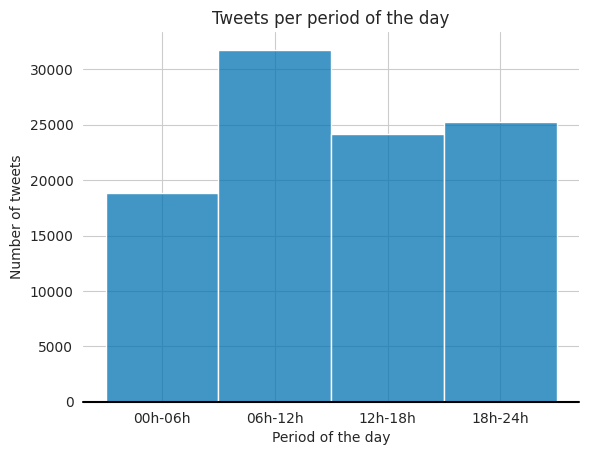

In [11]:
db = db.sort_values(by='period')
sns.set_style('whitegrid')
axis = sns.histplot(data=db, x= 'period')
axis.set(frame_on=False)
axis.axhline(0, color='k', clip_on=False)
plt.xlabel('Period of the day')
plt.ylabel('Number of tweets')
plt.title('Tweets per period of the day')
plt.show()

No histograma acima, verifica-se a maioria dos tweets publicados concentram-se no período entre 06h-12h. 
A relação entre polaridade dos tweets pode ser observada pelo gráfico a seguir:

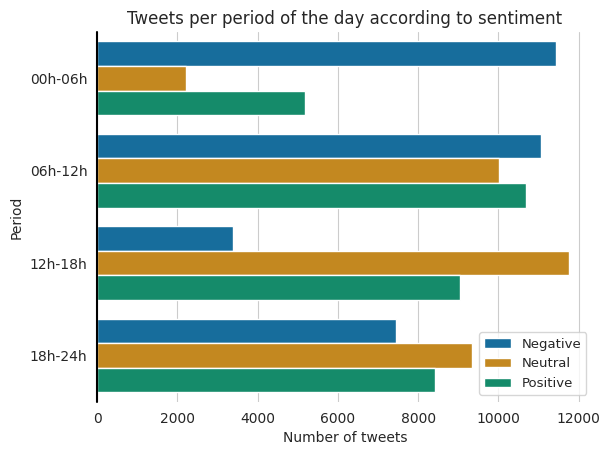

In [12]:
sns.set_style('whitegrid')
axis = sns.countplot(data=db, y='period', hue='sentiment', order = lista_ord)
                   
axis.set(frame_on=False)
axis.axvline(0, color='k', clip_on=False)
plt.ylabel('Period')
plt.xlabel('Number of tweets')
plt.title('Tweets per period of the day according to sentiment')
plt.legend(fontsize='9.5')
plt.show()

Observa-se que no período entre 00h-06h a maior parte da publicação dos tweets tende a uma polaridade negativa, ligeiramente seguida do período subsequente (06h-12h). 
Já publicações com polaridade positiva são percebidas em maior número no perído entre 06h-12h, onde as polaridade quese se equiparam, mas em nenhum dos períodos destacados encontram-se à frente dos negativos.
Por sua vez, publicações com polaridade majoritariamente neutras são encontrados nos períodos entre 12h-18h e 18h-24h.

## 1.3. Palavras mais frequentes

### Stopwords

In [13]:
# Configuração inicial
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('portuguese')


# Lista de stopword
stopwords = set(STOPWORDS)
stopwords.update(["Bolsonaro", "Haddad", "a","b","c","d","fato","ela","estou","nem","tudo","p","pq","quando","dele","RT","por","de","dar","pois","em", "ah",'um','da','ser','aqui','vou','dos','ter','não','ao','sou','seu','à','n','se','esse','uma','mais','ele','fazendo','você','pode','essa','é','mas','segue','pra','isso','vez','para','muito','pelo','pela','são', 'na','vamos', "https",'t',"co",'c','New','eu','seis','retweets','ano','pessoa','likes','vai','que','ou','anos','7dias','tirou','tem','q','0','O','e','os','assim','só','mesmo','tá','pro','votar','pessoas','vc'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joseaurelio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Nuvem de palavras período total

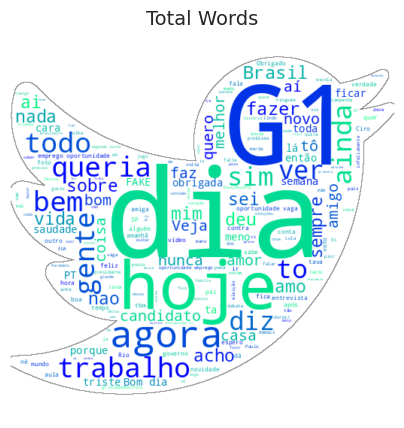

In [14]:
tweet_text = db.tweet_text

# Concatena as palavras
tweets = " ".join(s for s in tweet_text)

# importando imagem
imagem = cv2.imread("../data/external/Twitter-Logo.png")
gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(gray,250, 255, cv2.THRESH_BINARY)


# Gera uma wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                      mask=mask,
                      colormap="winter",
                      background_color="white",    
                      contour_width = 0.5,
                      contour_color = "gray",
                      width=2000, height=800).generate(tweets)

plt.figure(figsize = (5, 5), facecolor = 'white') # tamanho do gráfico
plt.title("Total Words", fontsize=14)
plt.imshow(wordcloud, interpolation = 'bilinear') # plotagem da nuvem de palavras
plt.axis('off') # remove as bordas
plt.show() # mostra a word cloud

### Nuvem de palavras período 00h-06h

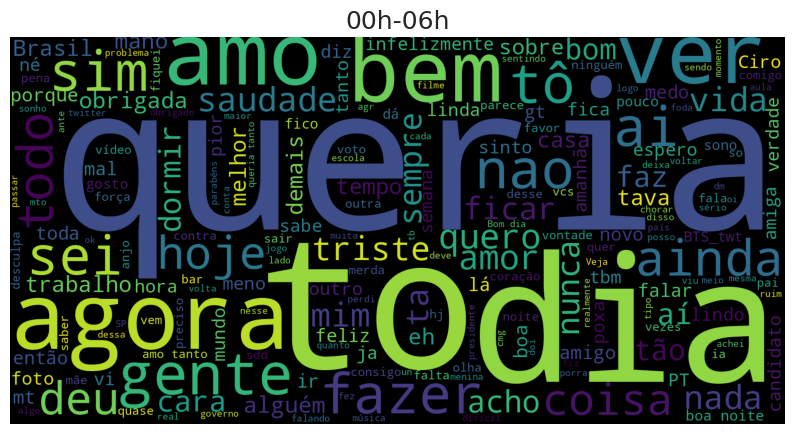

In [15]:
tweet_text = db[db['period']=='00h-06h'].tweet_text 

# Concatena as palavras
tweets = " ".join(s for s in tweet_text)

# Gera uma wordcloud
wordcloud_md = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(tweets)

# Mostra a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud_md, interpolation='bilinear')
ax.set_axis_off()
plt.title("00h-06h", fontsize=18)
plt.imshow(wordcloud_md)

### Nuvem de palavras 06h-12h

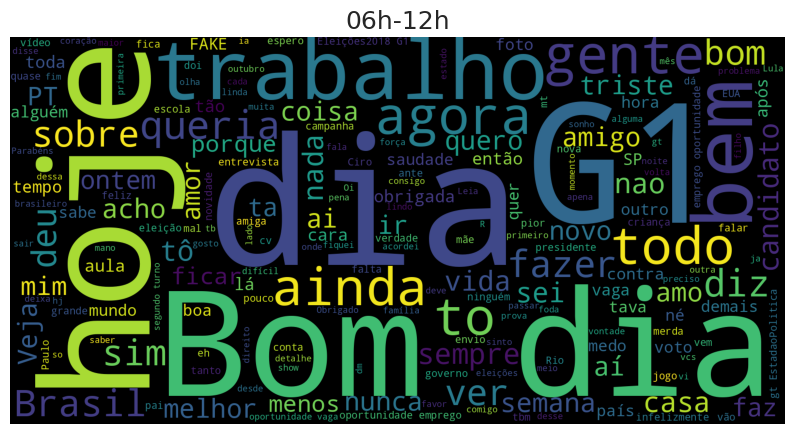

In [16]:
tweet_text = db[db['period']=='06h-12h'].tweet_text 

# Concatena as palavras
tweets = " ".join(s for s in tweet_text)

# Gera uma wordcloud
wordcloud_mn = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(tweets)

# Mostra a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud_mn, interpolation='bilinear')
ax.set_axis_off()
plt.title("06h-12h", fontsize=18)
plt.imshow(wordcloud_mn)

### Nuvem de palavras período 12h-18h

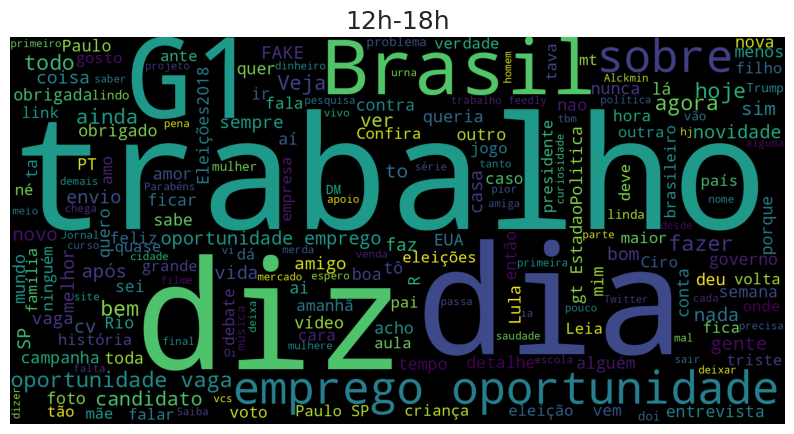

In [17]:
tweet_text = db[db['period']=='12h-18h'].tweet_text 

# Concatena as palavras
tweets = " ".join(s for s in tweet_text)

# Gera uma wordcloud
wordcloud_td = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(tweets)

# Mostra a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud_td, interpolation='bilinear')
ax.set_axis_off()
plt.title("12h-18h", fontsize=18)
plt.imshow(wordcloud_td)


### Nuvem de palavras 18h-24h

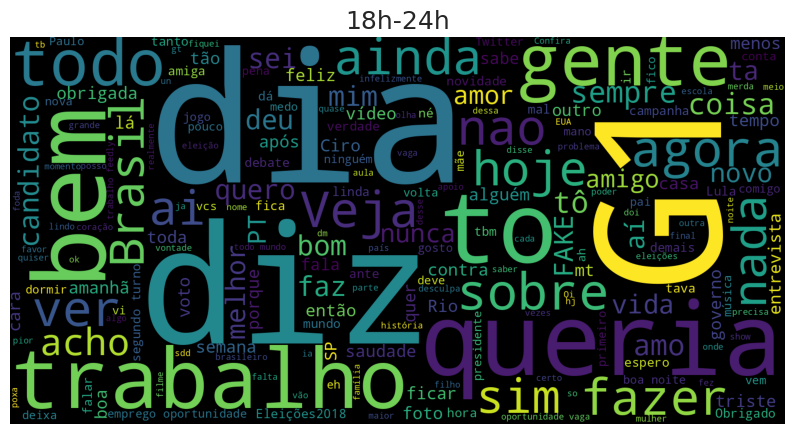

In [18]:
tweet_text = db[db['period']=='18h-24h'].tweet_text 

# Concatena as palavras
tweets = " ".join(s for s in tweet_text)

# Lista de stopword
stopwords = set(STOPWORDS)
stopwords.update(["Bolsonaro", "Haddad", "a","b","c","d","fato","ela","estou","nem","tudo","p","pq","quando","dele","RT","por","de",'dar','pois','em','um','da','ser','aqui','vou','dos','ter','não','ao','sou','seu','à','n','se','esse','uma','mais','ele','fazendo','você','pode','essa','é','mas','segue','pra','isso','vez','para','muito','pelo','pela','são', 'na','vamos','https','t','co','c','New','eu','seis','retweets','ano','pessoa','likes','vai','que','ou','anos','7dias','tirou','tem','q','0','O','e','os','assim','só','mesmo','tá','pro','votar','pessoas','vc'])

# Gera uma wordcloud
wordcloud_nt = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(tweets)

# Mostra a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud_nt, interpolation='bilinear')
ax.set_axis_off()
plt.title("18h-24h", fontsize=18)
plt.imshow(wordcloud_nt)

### Nuvem de palavras sentimento Negativo

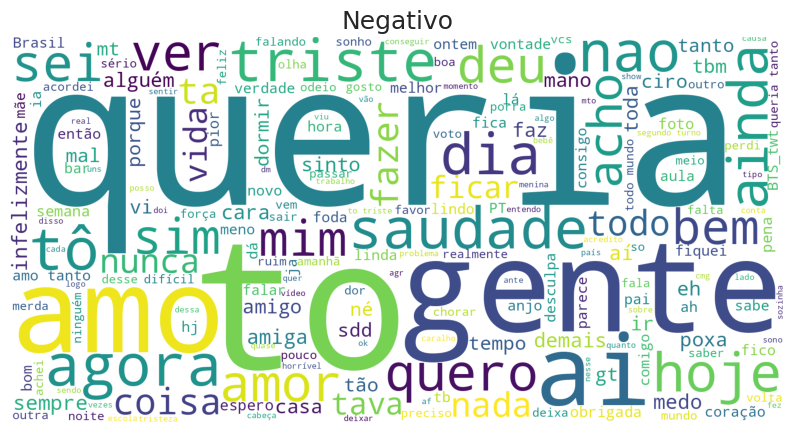

In [19]:
tweet_text = db[db['sentiment']=='Negative'].tweet_text

# Concatena as palavras
tweets = " ".join(s for s in tweet_text)

# Gera uma wordcloud
wordcloud_negative = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=1600, height=800).generate(tweets)

# Mostra a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud_negative, interpolation='bilinear')
ax.set_axis_off()
plt.title("Negativo", fontsize=18)
plt.imshow(wordcloud_negative)

### Nuvem de palavras sentimento Positivo

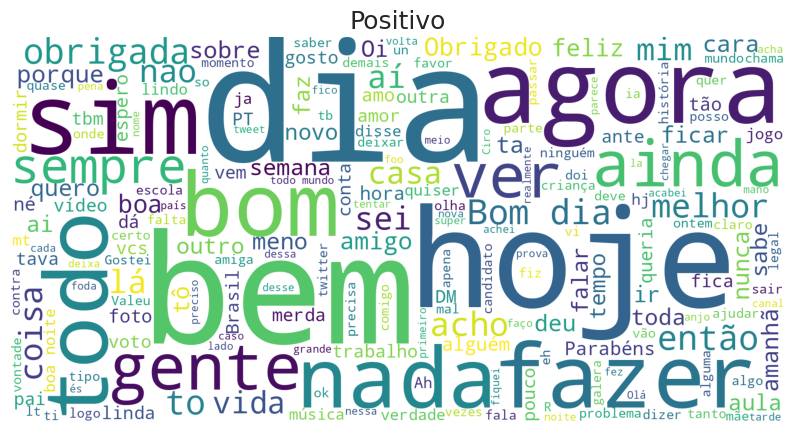

In [20]:
tweet_text = db[db['sentiment']=='Positive'].tweet_text

# Concatena as palavras
tweets = " ".join(s for s in tweet_text)

# Gera uma wordcloud
wordcloud_positive = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=1600, height=800).generate(tweets)

# Mostra a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud_positive, interpolation='bilinear')
ax.set_axis_off()
plt.title("Positivo", fontsize=18)
plt.imshow(wordcloud_positive)

## N-gram

In [21]:
tweet_text_ngr = db.dropna(subset=['tweet_text'], axis=0)['tweet_text']

'''remover stopwords'''

# Função
def get_top_ngram(corpus, n=None):       
    vec = CountVectorizer(ngram_range=(n, n), stop_words = stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)   
    sum_words = bag_of_words.sum(axis=0)    
    
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()] 
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:10]


### Bigrama

/home/joseaurelio/.cache/pypoetry/virtualenvs/src-2zHzSJE6-py3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bolsonaro', 'haddad', 'new', 'rt'] not in stop_words.
  warnings.warn(


<AxesSubplot:title={'center':'Bigrama'}>

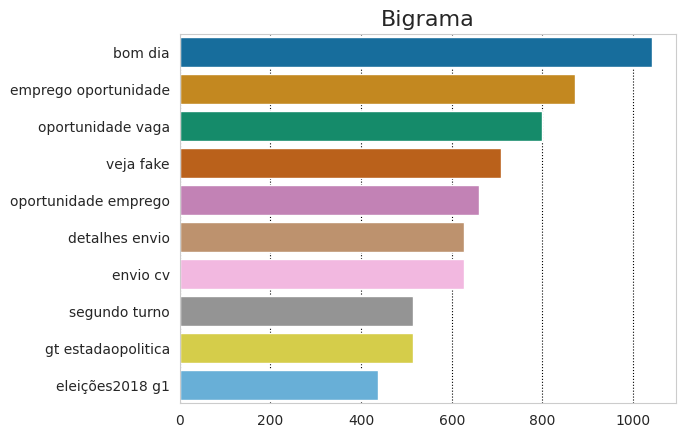

In [22]:
#Gráfico Bigrama

top_n_bigrams=get_top_ngram(tweet_text_ngr,2)[:10]

sns.set_style("whitegrid", {"grid.color": "k", "grid.linestyle": ":"})
plt.title('Bigrama', fontsize=16)
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

### Trigrama

/home/joseaurelio/.cache/pypoetry/virtualenvs/src-2zHzSJE6-py3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bolsonaro', 'haddad', 'new', 'rt'] not in stop_words.
  warnings.warn(


<AxesSubplot:title={'center':'Trigrama'}>

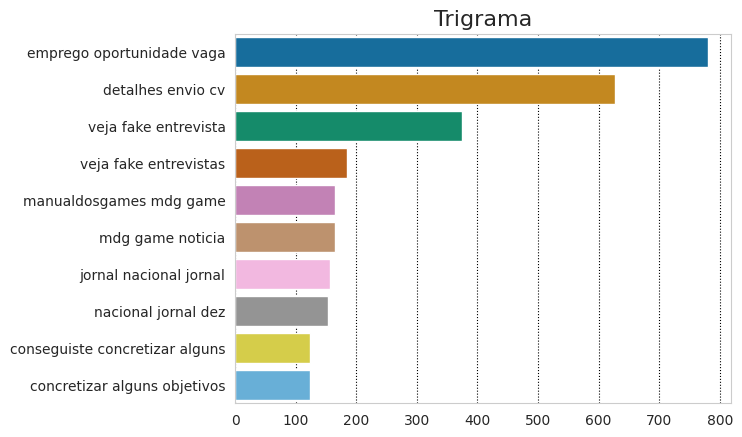

In [23]:
#Gráfico Trigrama

top_n_trigrams=get_top_ngram(tweet_text_ngr,3)[:20]

sns.set_style("whitegrid", {"grid.color": "k", "grid.linestyle": ":"})
plt.title('Trigrama', fontsize=16)
x,y=map(list,zip(*top_n_trigrams)) 
sns.barplot(x=y,y=x) 

## 2. Perguntas de partida e hipóteses

Com base na análise dos dados referentes a classificação de sentimentos do twitter, surgem as seguintes perguntas:
1. Em alguns intervalos do dia existem mais tweets do que em outros?
2. Qual correlação existente entre polaridade do sentimento e o período do dia?
3. O conteúdo do tweet é relevante para a avaliação do sentimento e/ ou período do dia?
    
Como hipóteses temos:
1. Disponibilidade das pessoas pode variar conforme o tempo e influenciar no envio de mensagens.
2. Fatores externos podem influenciar nos assuntos mais utilizados em tweets.
3. Conteúdos variam com o passar dos dias, dando dinamicidade às análises.
4. Conteúdo é avaliado por palavras-chave e mostram uma tendência de polaridade do sentimento em relação ao assunto dos tweets.
5. Condições de estabilidade emocional podem influenciar, como insônia, estresse ou estado de ânimo, podem influenciar na disposição de publicações e na respectiva polaridade.

## 3. Insights

Como observado nos gráficos, os períodos de positividade e negatividade oscilam durante o dia.
1. A variabilidade de assuntos durante períodos do dia e dias da semana difere para sentimento positivos e negativos.
2. Fatores pessoais, sociais e regionais podem influenciar na evolução de cada assunto, alterando conforme determinados períodos e dias.
3. Palavras-chave usualmente são utilizadas e repetidas, permitindo identificar sentimentos, em uma classificação por polaridade.
4. Da mesma forma, podem auxiliar a estabelecer padrões de sentimentos e assuntos, conforme períodos do dia e dias da semana.
5. Tendência de maior disponibilidade de publicações (totais) no período entre 06h-12h e publicações negativas entre 00h-06h, por exemplo.